# How Being Active Effects Your Sleep

#### Halil Mert Kartal

For mammals, including humans, sleep is crucial. You benefit greatly from getting enough sleep, which increases your energy and productivity.

We now have several tools and devices thanks to technology that can improve the way we sleep. Typically, they monitor you when you're asleep. You can check the data that is recorded from the time you go to sleep till you wake up to see how well you slept. However, a lot of consumers find this raw data to be bizarre. To draw conclusions especially for this group of users, we therefore attempted to examine the Fitbit data.

In our project, data is primarily examined like following: whether or not the amount of sedentary activity (lazy activities like watching TV or scrolling through Twitter in bed) and true activity (jogging, fitness, etc.) we do, have a significant impact on our ability to fall asleep. Some people who struggle with sleep may benefit from this since it may persuade them that doing more (or less) activities—whether sedentary or genuine—will effect a person's sleep quality and total sleep time.


## Table of Content

[Problem](#problem)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling](#modeling)   
[Evaluation](#evaluation)   
[References](#references)   


## Problem <a class="anchor" id="problem"></a>

Problem is to find relation between the duration of making activities of any kind and the total sleep time in a daily basis.

## Data Understanding<a class="anchor" id="data_understanding"></a>

Data can be found here: [link](https://www.kaggle.com/code/katiehuangx/case-study-bellabeat-using-python/data) Some csv files "dailyActivity_merged.csv" and "sleepDay_merged.csv" have been used as they have daily data. "dailyActivity_merged.csv" has distances time, and calories burnt for daily activities. "sleepDay_merged.csv" has asleep minutes and total time in bed. These are recorded with the help of a FitBit device.

## Data Preparation<a class="anchor" id="data_preparation"></a>

Columns that will not be used may be dropped and some columns can be merged to increase the performance.

In [66]:
# Neccessary imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, auc

In [67]:
# Load the csv files

daily_activity = pd.read_csv("dataset/dailyActivity_merged.csv")
sleep_day = pd.read_csv("dataset/sleepDay_merged.csv")

In [68]:
# Drop the unneccessary columns

daily_activity.drop(columns=["TrackerDistance", "LoggedActivitiesDistance", "VeryActiveDistance", "ModeratelyActiveDistance", 
                            "LightActiveDistance", "SedentaryActiveDistance"], inplace=True)

Check if there are null values

In [69]:
daily_activity.isna().sum()

Id                      0
ActivityDate            0
TotalSteps              0
TotalDistance           0
VeryActiveMinutes       0
FairlyActiveMinutes     0
LightlyActiveMinutes    0
SedentaryMinutes        0
Calories                0
dtype: int64

In [70]:
sleep_day.isna().sum()

Id                    0
SleepDay              0
TotalSleepRecords     0
TotalMinutesAsleep    0
TotalTimeInBed        0
dtype: int64

Shapes of both csv files

In [71]:
print("daily_activity.csv shape: ", daily_activity.shape)
print("sleep_day.csv shape: ",sleep_day.shape)

daily_activity.csv shape:  (940, 9)
sleep_day.csv shape:  (413, 5)


Both tables have user id column. Find the users in common between both tables by using their id's.

In [72]:
daily_activity_ids = pd.unique(daily_activity["Id"])
sleep_day_ids = pd.unique(sleep_day["Id"])

# Find the users that we have both their activity and sleep data
common = [id for id in daily_activity_ids if id in sleep_day_ids]

print("ID's of common users are:\n", common)
print("Number of common users is", len(common))

ID's of common users are:
 [1503960366, 1644430081, 1844505072, 1927972279, 2026352035, 2320127002, 2347167796, 3977333714, 4020332650, 4319703577, 4388161847, 4445114986, 4558609924, 4702921684, 5553957443, 5577150313, 6117666160, 6775888955, 6962181067, 7007744171, 7086361926, 8053475328, 8378563200, 8792009665]
Number of common users is 24


Merge all activity minutes into total_active_minutes.

In [73]:
# First, gather the activity minutes into "total_activity_minutes" column

daily_activity["total_active_minutes"] = daily_activity["VeryActiveMinutes"] + daily_activity["FairlyActiveMinutes"] + \
                                        daily_activity["LightlyActiveMinutes"] + daily_activity["SedentaryMinutes"]

daily_activity.head()

,Id,ActivityDate,TotalSteps,TotalDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,total_active_minutes
0,1503960366,4/12/2016,13162,8.50,25,13,328,728,1985,1094
1,1503960366,4/13/2016,10735,6.97,21,19,217,776,1797,1033
2,1503960366,4/14/2016,10460,6.74,30,11,181,1218,1776,1440
3,1503960366,4/15/2016,9762,6.28,29,34,209,726,1745,998
4,1503960366,4/16/2016,12669,8.16,36,10,221,773,1863,1040


Both tables have "date" but their format is different. So rename the columns as "Date" and reformat them.

In [74]:
daily_activity.rename(columns={"ActivityDate":"Date"}, inplace=True)
sleep_day.rename(columns={"SleepDay":"Date"}, inplace=True)

In [75]:
# Drop the unneccessary 12.00.00 AM's

dates = sleep_day["Date"].values
for i in range(len(dates)):
    splitted = dates[i].split(" ")
    dates[i] = splitted[0]
sleep_day["Date"] = dates

In [76]:
# Change the Date formats

sleep_day["Date"] = pd.to_datetime(sleep_day["Date"], format="%m/%d/%Y")
print(sleep_day["Date"])

daily_activity["Date"] = pd.to_datetime(daily_activity["Date"], format="%m/%d/%Y")
print(daily_activity["Date"])

0     2016-04-12
1     2016-04-13
2     2016-04-15
3     2016-04-16
4     2016-04-17
         ...    
408   2016-04-30
409   2016-05-01
410   2016-05-02
411   2016-05-03
412   2016-05-04
Name: Date, Length: 413, dtype: datetime64[ns]
0     2016-04-12
1     2016-04-13
2     2016-04-14
3     2016-04-15
4     2016-04-16
         ...    
935   2016-05-08
936   2016-05-09
937   2016-05-10
938   2016-05-11
939   2016-05-12
Name: Date, Length: 940, dtype: datetime64[ns]


A join operation must be done to examine all users in one table with all their sleep and activity features.

In [77]:
# Now join the tables into the new table to gather same ids and dates to further processing

df_activity_with_sleep = pd.merge(daily_activity, sleep_day, on=["Id", "Date"])

df_activity_with_sleep.drop(columns=["TotalSleepRecords"], inplace=True)


# Print the latest version of our data table
print(df_activity_with_sleep.shape)
df_activity_with_sleep.head(10)

(413, 12)


,Id,Date,TotalSteps,TotalDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,total_active_minutes,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,2016-04-12,13162,8.50,25,13,328,728,1985,1094,327,346
1,1503960366,2016-04-13,10735,6.97,21,19,217,776,1797,1033,384,407
2,1503960366,2016-04-15,9762,6.28,29,34,209,726,1745,998,412,442
3,1503960366,2016-04-16,12669,8.16,36,10,221,773,1863,1040,340,367
4,1503960366,2016-04-17,9705,6.48,38,20,164,539,1728,761,700,712
5,1503960366,2016-04-19,15506,9.88,50,31,264,775,2035,1120,304,320
6,1503960366,2016-04-20,10544,6.68,28,12,205,818,1786,1063,360,377
7,1503960366,2016-04-21,9819,6.34,19,8,211,838,1775,1076,325,364
8,1503960366,2016-04-23,14371,9.04,41,21,262,732,1949,1056,361,384
9,1503960366,2016-04-24,10039,6.41,39,5,238,709,1788,991,430,449


Histograms are useful to find more about data in terms of distribution.

Text(0.5, 0, 'Total Active Minutes')

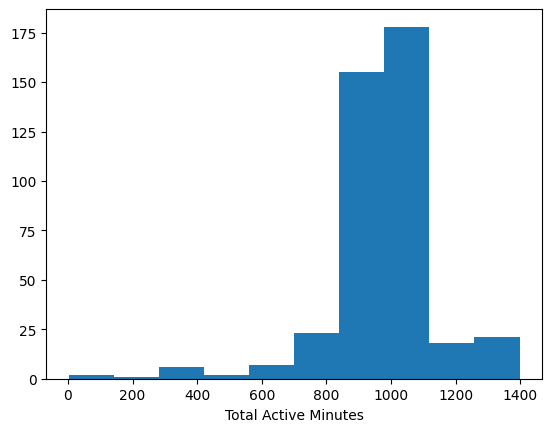

In [78]:
# Histogram plot of total active minutes

plt.hist(df_activity_with_sleep["total_active_minutes"])
plt.xlabel("Total Active Minutes")

Text(0.5, 0, 'Total Asleep Minutes')

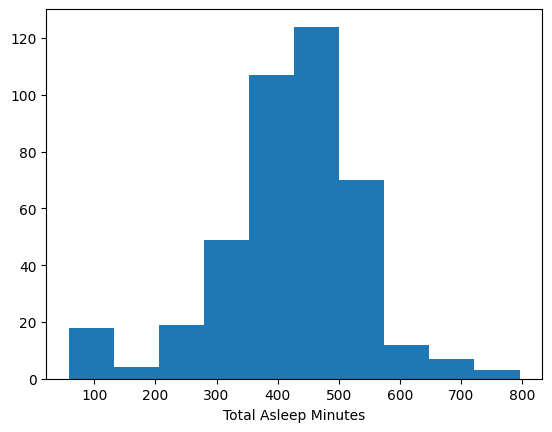

In [79]:
# Histogram plot of total asleep minutes

plt.hist(df_activity_with_sleep["TotalMinutesAsleep"])
plt.xlabel("Total Asleep Minutes")

The "total_active_mins" ingridients visualized to clearly see how is the total active minutes distributed as various activity types are gathered into it.

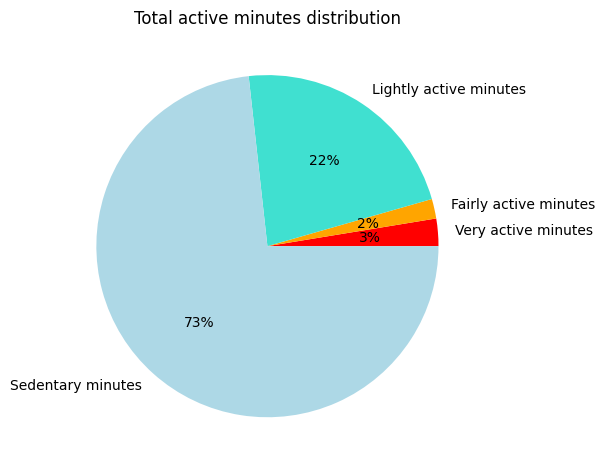

In [80]:
# Get the sums
SedentaryMinutes = df_activity_with_sleep["SedentaryMinutes"].sum()
LightlyActiveMinutes = df_activity_with_sleep["LightlyActiveMinutes"].sum()
FairlyActiveMinutes = df_activity_with_sleep["FairlyActiveMinutes"].sum()
VeryActiveMinutes = df_activity_with_sleep["VeryActiveMinutes"].sum()

# Plot the pie chart

slices = [VeryActiveMinutes, FairlyActiveMinutes, LightlyActiveMinutes, SedentaryMinutes]
labels = ["Very active minutes", "Fairly active minutes", "Lightly active minutes", "Sedentary minutes"]
colors = ["red", "orange", "turquoise", "lightblue"]

plt.style.use("default")
plt.pie(slices, labels = labels, 
        colors = colors, autopct = "%0.0f%%")
plt.title("Total active minutes distribution")
plt.tight_layout()
plt.show()

Correlation heatmap helps us to find correlated features. It seems there are reversely correlated columns we can make use of.

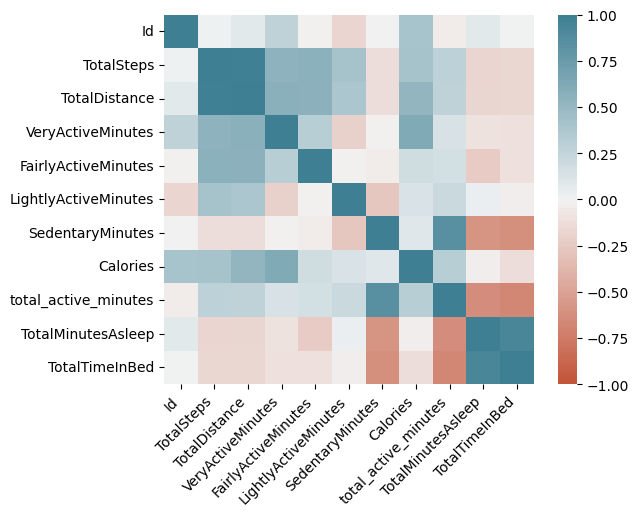

In [81]:
# Correlation heatmap of data

corr = df_activity_with_sleep.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Scatter plots gives better understanding about data.

Text(0, 0.5, 'Total Asleep Minutes')

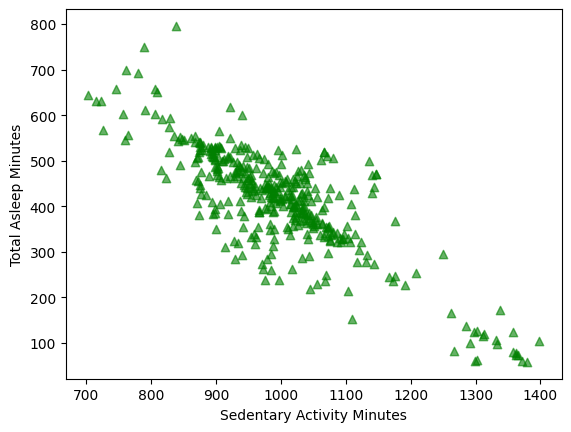

In [82]:
plt.scatter(x_axis, y_axis,color='g', marker='^', alpha=0.6)
plt.xlabel("Sedentary Activity Minutes")
plt.ylabel("Total Asleep Minutes")

To handle the outliers, create a box plot and remove the outliers according to it.

<AxesSubplot:>

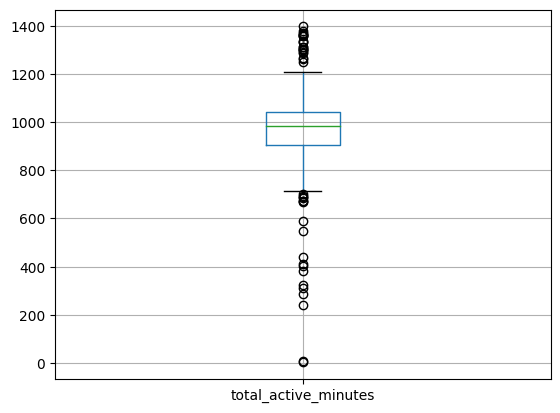

In [83]:
# Creates a box plot of total_active_minutes

df_activity_with_sleep.boxplot(column=['total_active_minutes'])

In [84]:
# Remove outliers which is seen on the boxplot

df_activity_with_sleep = df_activity_with_sleep[df_activity_with_sleep["total_active_minutes"] > 700] 

Scaling must be done for getting data ready your linear regression model.

In [85]:
x_axis = df_activity_with_sleep["total_active_minutes"].values
y_axis = df_activity_with_sleep["TotalMinutesAsleep"].values


X_train, X_test, y_train, y_test = train_test_split(x_axis, y_axis, test_size=0.2, random_state=0)

# Scale
scaler = StandardScaler()
X_train_ = X_train.reshape(-1, 1)
X_test_ = X_test.reshape(-1, 1)
X_train = scaler.fit_transform(X_train_)
X_test = scaler.transform(X_test_)

## Modeling<a class="anchor" id="modeling"></a>

A Lasso Regression model with cross validation will be used. Because the model is desired to find a relationship between two features. So it would be used in future with only entering an activity data to get a sleep prediction. It will be given a parameter space, and with hyperparameter optimization, the most accurate model will be selected.

In [86]:
# Train the model

regressor = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10], random_state=100).fit(X_train, y_train)
# Fit the model

regressor.fit(X_train, y_train)
# Predict

y_pred = regressor.predict(X_test)


## Evaluation<a class="anchor" id="evaluation"></a>

In [87]:
# Get the accuracies

train_score_regressor = regressor.score(X_train, y_train)
test_score_regressor = regressor.score(X_test, y_test)

print("Train score of LassoCV: ", train_score_regressor.round(2))
print("Test score of LassoCV: ", test_score_regressor.round(2))

Train score of LassoCV:  0.68
Test score of LassoCV:  0.69


Regression line can be seen below:

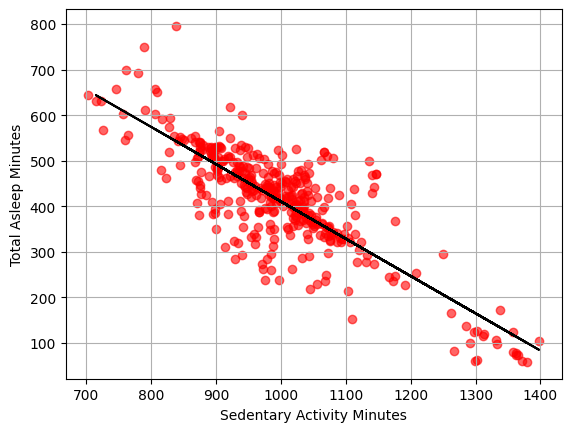

In [88]:
# Draw the scatter plot and line

line = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10], random_state=100).fit(X_train_, y_train)
line.fit(X_train_, y_train)
y_pred_line = line.predict(X_test_)

plt.scatter(x_axis, y_axis,color='r', alpha=0.6)
plt.xlabel("Sedentary Activity Minutes")
plt.ylabel("Total Asleep Minutes")
plt.grid(True)
plt.plot(X_test_, y_pred_line,color='black') 

Results can be interpreted as being more active making quality improvements onto your sleep as you tend to sleep less. Or being so active keeps you busy so you have least minutes to sleep. Some resources also tell excercising right before the bedtime may effect your sleep badly because it increases the blood pressure.

## References<a class="anchor" id="references"></a>

https://www.projectpro.io/recipes/deal-with-outliers-in-python

https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression

https://www.kaggle.com/datasets/arashnic/fitbit

https://www.w3schools.com/python/python_ml_scale.asp

https://www.sleepfoundation.org/physical-activity/exercise-and-sleep


**Disclaimer!** <font color='grey'>This notebook was prepared by Halil Mert Kartal for the *BBM467 - Data Intensive Applications* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>